# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import pytorch_lightning as pl
import torch 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
PyTorch Lightning -> {pl.__version__}
Torch -> {torch.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
PyTorch Lightning -> 1.6.1
Torch -> 1.11.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
path = Path('../../datasets/Ch13/')
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

daily_weather.ffill(inplace=True)

## Tranform the data sets
### Windowing

In [5]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [6]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

### Scale and split data

In [7]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [8]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [9]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



### Split into X and Y (Features and Target)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [11]:
def features_target(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [12]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [13]:
y_train_air.shape

torch.Size([102, 1])

In [14]:
x_train_air.shape

torch.Size([102, 5, 1])

# RNN/LSTM in PyTorch

## RNN Model
* The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [30]:
def train(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['n_features'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['n_features'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['n_features'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    plt.figure(figsize=(20, 10))
    
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    plt.title(f'{model_type}: Loss and Validation Loss per epoch')
    plt.plot(history['loss'], 'k--', label='loss')
    plt.plot(history['val_loss'], 'k', label='val_loss')
    plt.legend()
    
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    plt.title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    plt.legend(); plt.show()
    
    return model, history

### Air Passenger

In [17]:
params_air = {'input_size':x_train_air.shape[1],
'output_size':1,
'n_features':32,
'n_layers':1,
'epochs': 1000,
'print_every': 50,
'lr': 0.01,
'train_data': (x_train_air, y_train_air),
'val_data': (x_val_air, y_val_air),
'test_data': (x_test_air, y_test_air),
'idx': test_air.index,
'scale': scale_air}

0/1000 - Loss:  0.8839395642280579, val_loss: 1.4831132888793945
50/1000 - Loss:  0.07273057848215103, val_loss: 0.20050138235092163
100/1000 - Loss:  0.046147242188453674, val_loss: 0.144460991024971
150/1000 - Loss:  0.030447740107774734, val_loss: 0.08980948477983475
200/1000 - Loss:  0.019245829433202744, val_loss: 0.09025456756353378
250/1000 - Loss:  0.023933541029691696, val_loss: 0.06664163619279861
300/1000 - Loss:  0.02412116713821888, val_loss: 0.060965076088905334
350/1000 - Loss:  0.02103477157652378, val_loss: 0.06022152304649353
400/1000 - Loss:  0.02518078312277794, val_loss: 0.05450454354286194
450/1000 - Loss:  0.01778227835893631, val_loss: 0.06101847440004349
500/1000 - Loss:  0.02101949229836464, val_loss: 0.054873064160346985
550/1000 - Loss:  0.012329240329563618, val_loss: 0.05740949884057045
600/1000 - Loss:  0.01506916992366314, val_loss: 0.06521467119455338
650/1000 - Loss:  0.01684899628162384, val_loss: 0.06829112768173218
700/1000 - Loss:  0.01549618039280

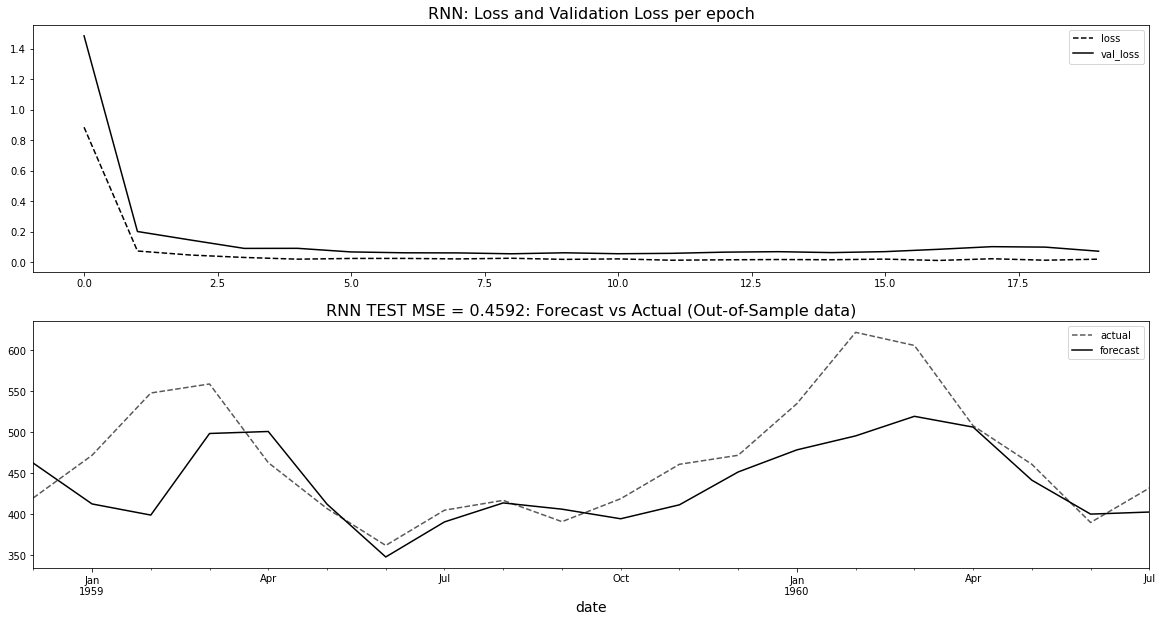

In [18]:
air_rnn, history_a_rnn = train('RNN', **params_air)

### Avg Daily Temperature

0/1000 - Loss:  1.2940106391906738, val_loss: 0.7429202795028687
50/1000 - Loss:  0.36348268389701843, val_loss: 0.30863985419273376
100/1000 - Loss:  0.33392804861068726, val_loss: 0.2993103265762329
150/1000 - Loss:  0.2924092710018158, val_loss: 0.32455846667289734
200/1000 - Loss:  0.28399014472961426, val_loss: 0.3570826053619385
250/1000 - Loss:  0.26717233657836914, val_loss: 0.35478055477142334
300/1000 - Loss:  0.26283782720565796, val_loss: 0.416912317276001
350/1000 - Loss:  0.3024033308029175, val_loss: 0.3441857695579529
400/1000 - Loss:  0.25248146057128906, val_loss: 0.38466599583625793
450/1000 - Loss:  0.28533345460891724, val_loss: 0.35854044556617737
500/1000 - Loss:  0.22429023683071136, val_loss: 0.3713832199573517
550/1000 - Loss:  0.19359539449214935, val_loss: 0.4052782654762268
600/1000 - Loss:  0.33482423424720764, val_loss: 0.2987842857837677
650/1000 - Loss:  0.28927040100097656, val_loss: 0.32322677969932556
700/1000 - Loss:  0.31924495100975037, val_loss: 

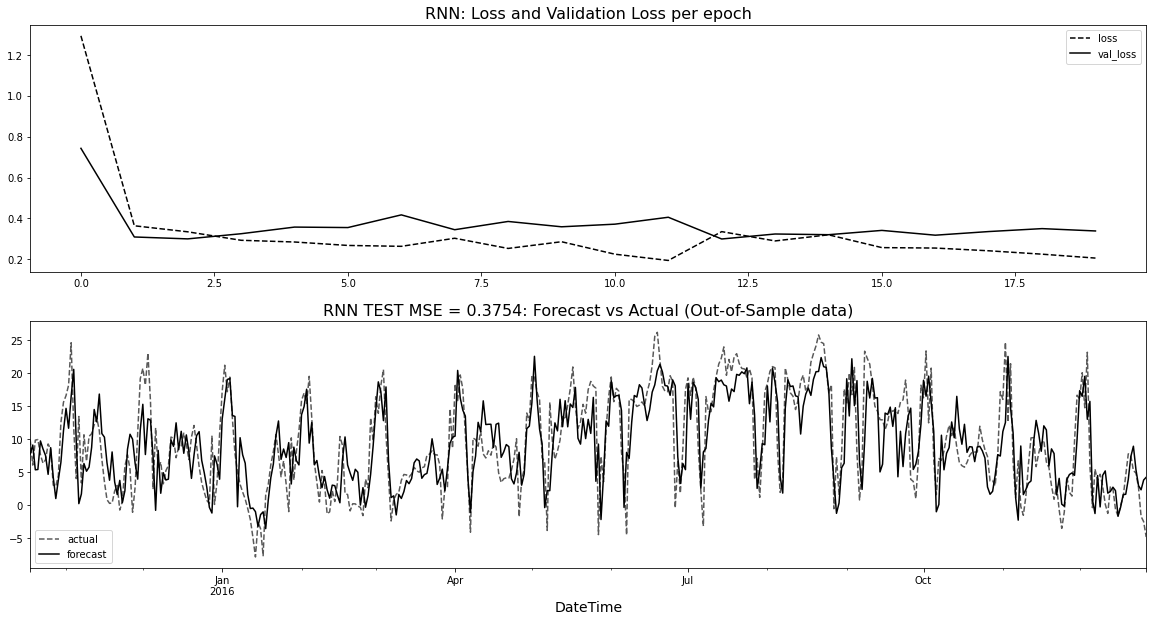

In [19]:
params_dw = {'input_size':x_train_air.shape[1],
'output_size':1,
'n_features':32,
'n_layers':1,
'epochs': 1000,
'print_every': 50,
'lr': 0.01,
'train_data': (x_train_dw, y_train_dw),
'val_data': (x_val_dw, y_val_dw),
'test_data': (x_test_dw, y_test_dw),
'idx': test_dw.index,
'scale': scale_dw}

dw_rnn, history_dw_rnn = train('RNN', **params_dw)

### Energy Consumption

0/1000 - Loss:  1.1111901998519897, val_loss: 1.3625916242599487
50/1000 - Loss:  0.09125541150569916, val_loss: 0.2155386060476303
100/1000 - Loss:  0.06240342929959297, val_loss: 0.1831812858581543
150/1000 - Loss:  0.05886688828468323, val_loss: 0.15514874458312988
200/1000 - Loss:  0.05532609298825264, val_loss: 0.14467862248420715
250/1000 - Loss:  0.046176034957170486, val_loss: 0.13344787061214447
300/1000 - Loss:  0.04631004482507706, val_loss: 0.13700230419635773
350/1000 - Loss:  0.04738045483827591, val_loss: 0.14525684714317322
400/1000 - Loss:  0.04255048558115959, val_loss: 0.14299173653125763
450/1000 - Loss:  0.04206036403775215, val_loss: 0.1402791440486908
500/1000 - Loss:  0.0380546934902668, val_loss: 0.15738022327423096
550/1000 - Loss:  0.03470651060342789, val_loss: 0.16731220483779907
600/1000 - Loss:  0.034048885107040405, val_loss: 0.15030017495155334
650/1000 - Loss:  0.030200451612472534, val_loss: 0.16141852736473083
700/1000 - Loss:  0.039991285651922226, 

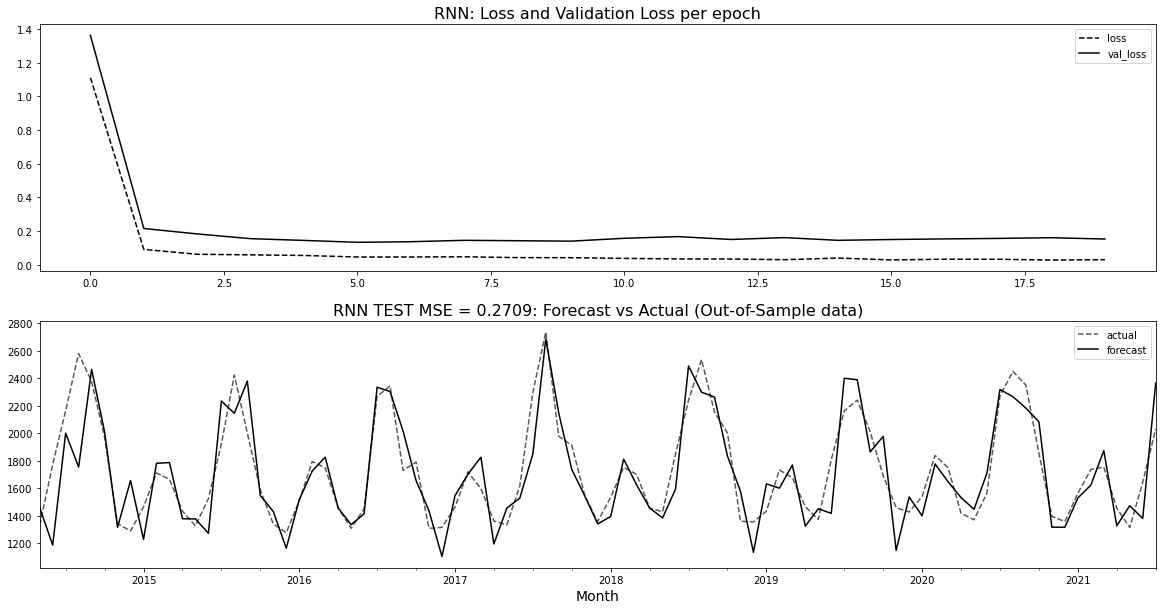

In [20]:
params_en = {'input_size':x_train_air.shape[1],
'output_size':1,
'n_features':32,
'n_layers':1,
'epochs': 1000,
'print_every': 50,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}

en_rnn, history_en_rnn = train('RNN', **params_en)

## LSTM Model 
* The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

### Air Passenger

0/1000 - Loss:  1.0286972522735596, val_loss: 2.1638083457946777
50/1000 - Loss:  0.09532219916582108, val_loss: 0.45465946197509766
100/1000 - Loss:  0.05158092454075813, val_loss: 0.13998350501060486
150/1000 - Loss:  0.03464382141828537, val_loss: 0.1507309079170227
200/1000 - Loss:  0.03397988900542259, val_loss: 0.26126059889793396
250/1000 - Loss:  0.024324879050254822, val_loss: 0.10414042323827744
300/1000 - Loss:  0.02225792407989502, val_loss: 0.16305139660835266
350/1000 - Loss:  0.01831725239753723, val_loss: 0.10815048217773438
400/1000 - Loss:  0.023196708410978317, val_loss: 0.1792759895324707
450/1000 - Loss:  0.014765230007469654, val_loss: 0.1113191619515419
500/1000 - Loss:  0.019187962636351585, val_loss: 0.1050463393330574
550/1000 - Loss:  0.01523686945438385, val_loss: 0.07802065461874008
600/1000 - Loss:  0.021540818735957146, val_loss: 0.07679086923599243
650/1000 - Loss:  0.013682253658771515, val_loss: 0.05491738021373749
700/1000 - Loss:  0.01461680512875318

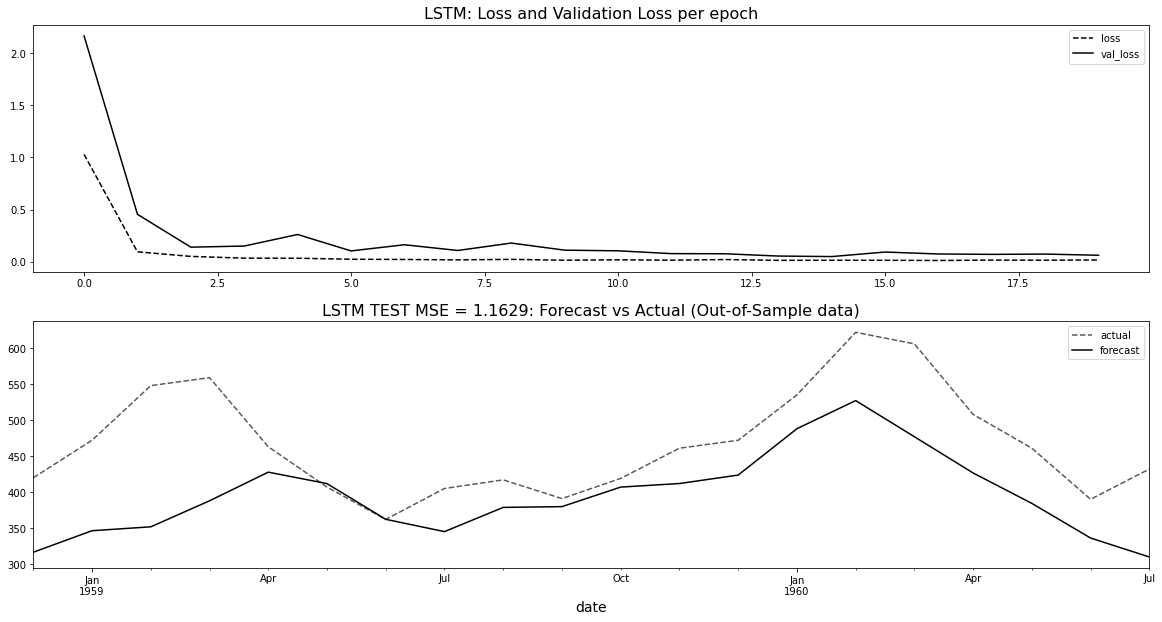

In [22]:
air_lstm, history_a_lstm = train('LSTM', **params_air)

### Avg Daily Temperature

0/1000 - Loss:  0.984826922416687, val_loss: 0.6970048546791077
50/1000 - Loss:  0.3602781593799591, val_loss: 0.30117690563201904
100/1000 - Loss:  0.29038891196250916, val_loss: 0.3105889558792114
150/1000 - Loss:  0.28329774737358093, val_loss: 0.2983997166156769
200/1000 - Loss:  0.19625887274742126, val_loss: 0.2515115439891815
250/1000 - Loss:  0.16901549696922302, val_loss: 0.27300602197647095
300/1000 - Loss:  0.1646886169910431, val_loss: 0.2720585763454437
350/1000 - Loss:  0.15385232865810394, val_loss: 0.29253795742988586
400/1000 - Loss:  0.13477596640586853, val_loss: 0.31154900789260864
450/1000 - Loss:  0.13056370615959167, val_loss: 0.3249976634979248
500/1000 - Loss:  0.12124399840831757, val_loss: 0.3507324457168579
550/1000 - Loss:  0.1559026688337326, val_loss: 0.39338573813438416
600/1000 - Loss:  0.1067948266863823, val_loss: 0.3763878643512726
650/1000 - Loss:  0.1038607731461525, val_loss: 0.3968885540962219
700/1000 - Loss:  0.10225413739681244, val_loss: 0.43

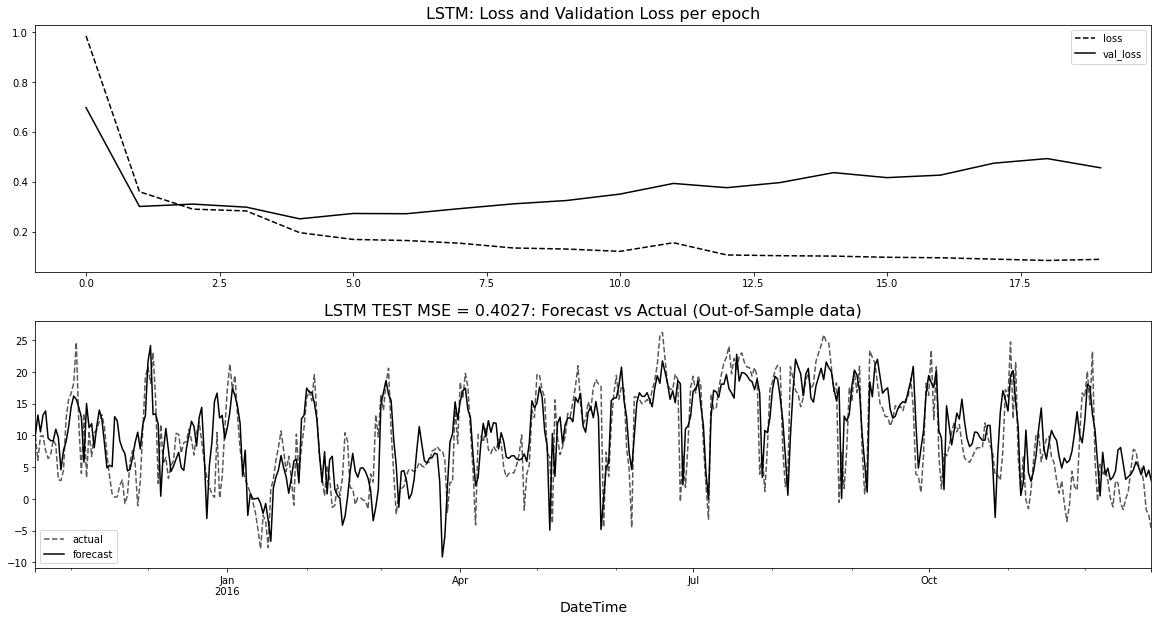

In [23]:
dw_lstm, history_dw_lstm = train('LSTM', **params_dw)

### Energy Consumption

0/1000 - Loss:  1.0057274103164673, val_loss: 1.425818681716919
50/1000 - Loss:  0.07899110019207001, val_loss: 0.23046480119228363
100/1000 - Loss:  0.06487146019935608, val_loss: 0.17428019642829895
150/1000 - Loss:  0.053890544921159744, val_loss: 0.17450013756752014
200/1000 - Loss:  0.049485404044389725, val_loss: 0.1773262470960617
250/1000 - Loss:  0.039328452199697495, val_loss: 0.1979617327451706
300/1000 - Loss:  0.036781325936317444, val_loss: 0.21650396287441254
350/1000 - Loss:  0.03456365689635277, val_loss: 0.1827758550643921
400/1000 - Loss:  0.03498007729649544, val_loss: 0.14014925062656403
450/1000 - Loss:  0.028654269874095917, val_loss: 0.14337721467018127
500/1000 - Loss:  0.03069024346768856, val_loss: 0.14813628792762756
550/1000 - Loss:  0.023930111899971962, val_loss: 0.15679462254047394
600/1000 - Loss:  0.025929654017090797, val_loss: 0.1616140753030777
650/1000 - Loss:  0.021550564095377922, val_loss: 0.15090753138065338
700/1000 - Loss:  0.0211994107812643

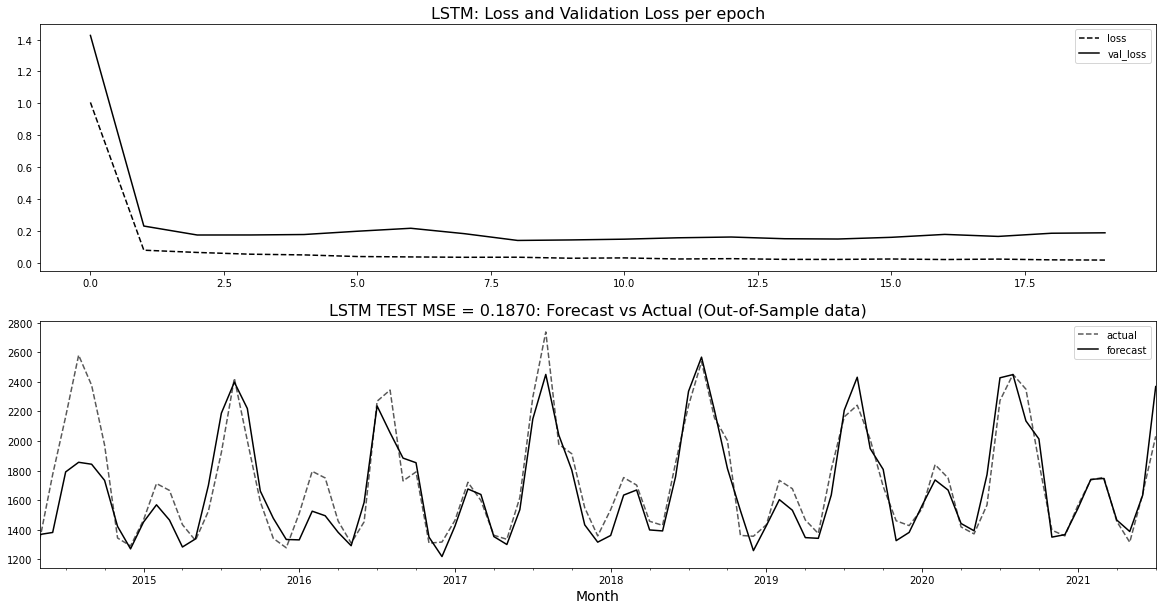

In [24]:
en_lstm, history_en_lstm = train('LSTM', **params_en)

## GRU
* The math from the PyTorch GRU documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [27]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.rnn(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

### Air Passenger

0/1000 - Loss:  1.21817946434021, val_loss: 2.990574359893799
50/1000 - Loss:  0.09679175168275833, val_loss: 0.34490102529525757
100/1000 - Loss:  0.045858234167099, val_loss: 0.14732728898525238
150/1000 - Loss:  0.033593472093343735, val_loss: 0.15823593735694885
200/1000 - Loss:  0.02540154755115509, val_loss: 0.11897597461938858
250/1000 - Loss:  0.028974488377571106, val_loss: 0.13734842836856842
300/1000 - Loss:  0.02459493838250637, val_loss: 0.09964346885681152
350/1000 - Loss:  0.01901482418179512, val_loss: 0.12108046561479568
400/1000 - Loss:  0.018802307546138763, val_loss: 0.12366951256990433
450/1000 - Loss:  0.024451950564980507, val_loss: 0.10190390795469284
500/1000 - Loss:  0.019674042239785194, val_loss: 0.15651385486125946
550/1000 - Loss:  0.013644106686115265, val_loss: 0.1149122565984726
600/1000 - Loss:  0.015043413266539574, val_loss: 0.08719784021377563
650/1000 - Loss:  0.01469733938574791, val_loss: 0.0663430467247963
700/1000 - Loss:  0.02200962044298649, 

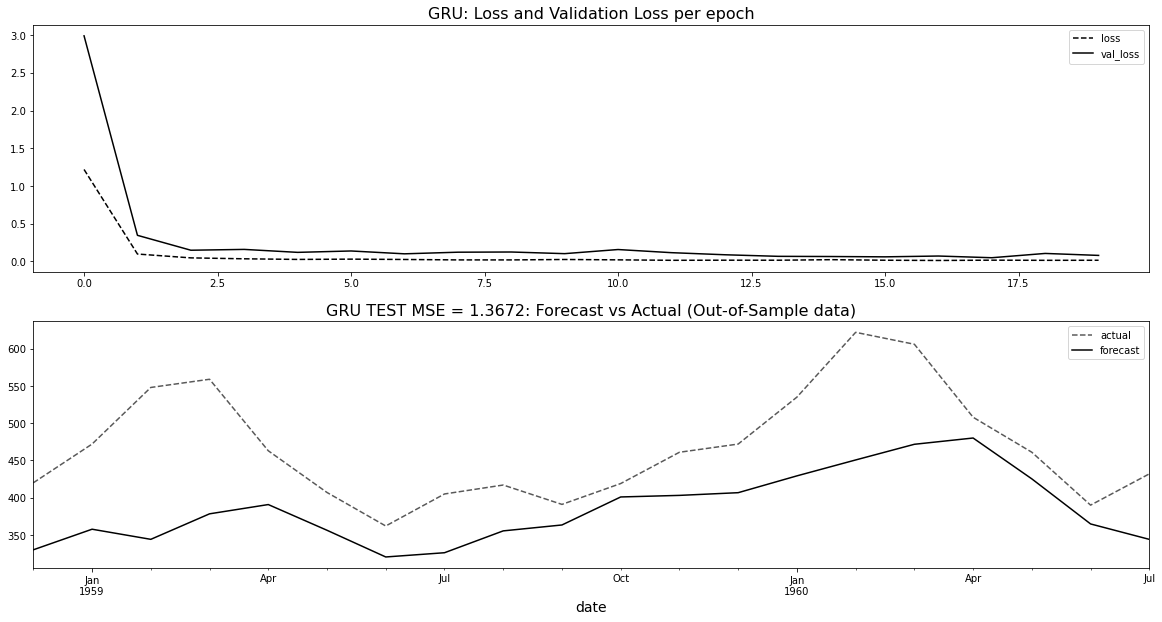

In [29]:
air_gru, history_a_gru = train('GRU', **params_air)

### Avg Daily Temperature

0/1000 - Loss:  1.0384451150894165, val_loss: 0.7422232627868652
50/1000 - Loss:  0.36564868688583374, val_loss: 0.3011828064918518
100/1000 - Loss:  0.2701271176338196, val_loss: 0.26469606161117554
150/1000 - Loss:  0.2084752470254898, val_loss: 0.24666665494441986
200/1000 - Loss:  0.18769048154354095, val_loss: 0.2631080150604248
250/1000 - Loss:  0.1681021749973297, val_loss: 0.26829707622528076
300/1000 - Loss:  0.1690037101507187, val_loss: 0.32763445377349854
350/1000 - Loss:  0.13846610486507416, val_loss: 0.3495456874370575
400/1000 - Loss:  0.12725304067134857, val_loss: 0.2996671199798584
450/1000 - Loss:  0.12331239134073257, val_loss: 0.30702507495880127
500/1000 - Loss:  0.11044149845838547, val_loss: 0.3039533197879791
550/1000 - Loss:  0.10381519794464111, val_loss: 0.3107951581478119
600/1000 - Loss:  0.10512799024581909, val_loss: 0.36413291096687317
650/1000 - Loss:  0.10004495084285736, val_loss: 0.4188522398471832
700/1000 - Loss:  0.08843148499727249, val_loss: 0

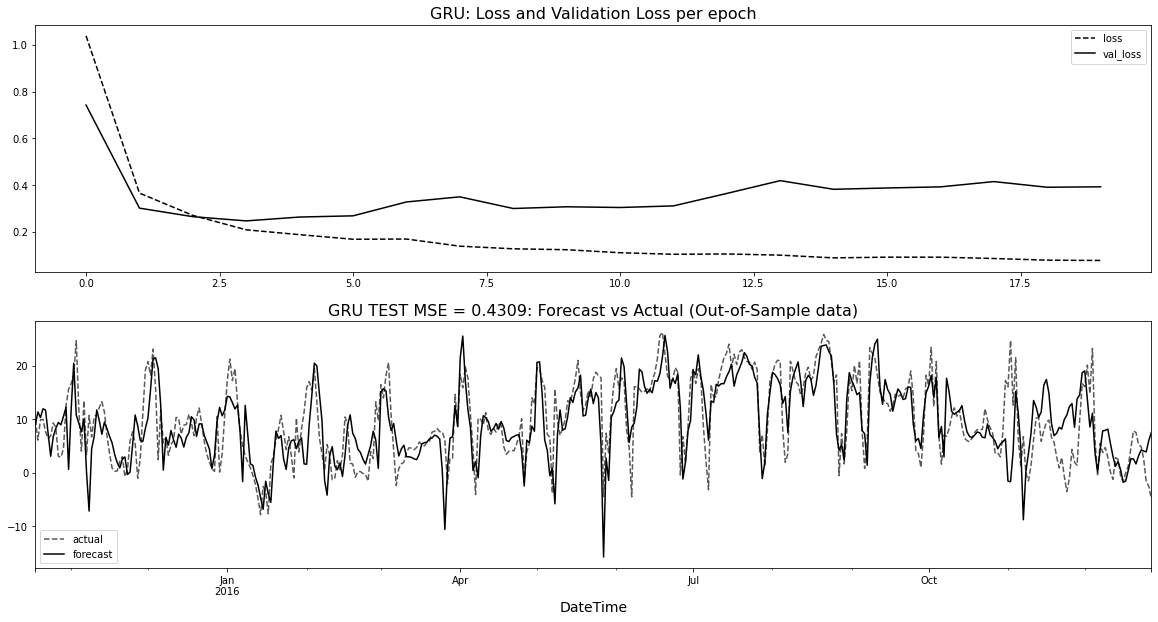

In [31]:
dw_gru, history_dw_gru = train('GRU', **params_dw)

### Energy Consumption

0/1000 - Loss:  1.0479040145874023, val_loss: 1.5339767932891846
50/1000 - Loss:  0.09295161068439484, val_loss: 0.21249188482761383
100/1000 - Loss:  0.06544514745473862, val_loss: 0.18107077479362488
150/1000 - Loss:  0.052566371858119965, val_loss: 0.1756192296743393
200/1000 - Loss:  0.054995257407426834, val_loss: 0.17805702984333038
250/1000 - Loss:  0.043781232088804245, val_loss: 0.16540171205997467
300/1000 - Loss:  0.043364256620407104, val_loss: 0.1709633320569992
350/1000 - Loss:  0.04032539576292038, val_loss: 0.1777251958847046
400/1000 - Loss:  0.03292480856180191, val_loss: 0.1802395135164261
450/1000 - Loss:  0.033034857362508774, val_loss: 0.17695562541484833
500/1000 - Loss:  0.029829848557710648, val_loss: 0.18598580360412598
550/1000 - Loss:  0.02833426371216774, val_loss: 0.20346607267856598
600/1000 - Loss:  0.03130493685603142, val_loss: 0.2017636001110077
650/1000 - Loss:  0.028509417548775673, val_loss: 0.21921560168266296
700/1000 - Loss:  0.02940033003687858

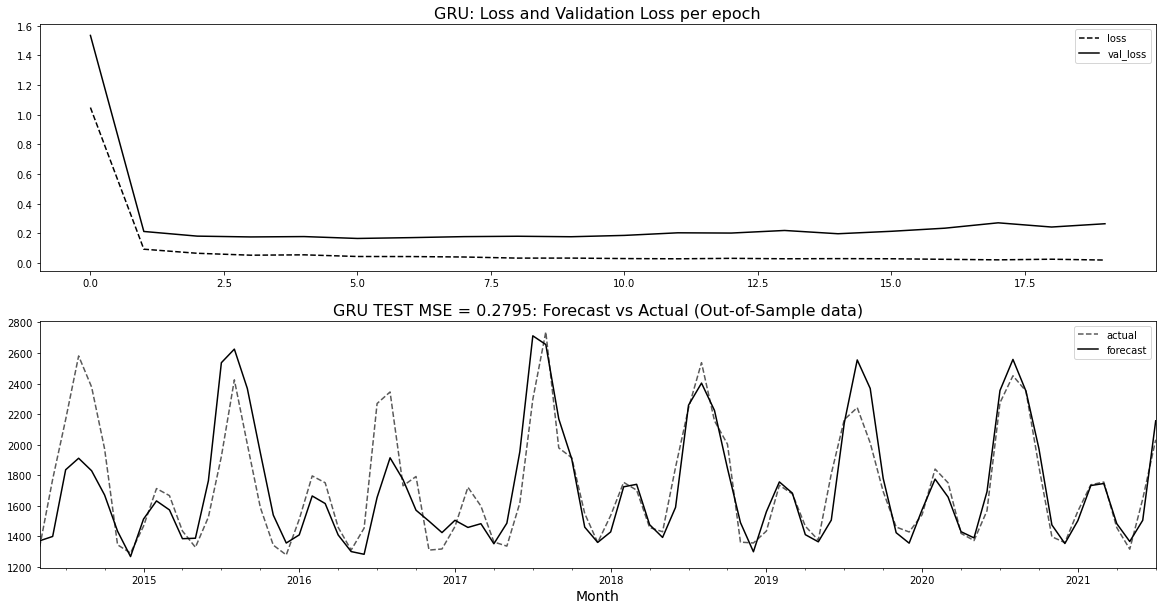

In [32]:
en_gru, history_en_gru = train('GRU', **params_en)